Run using keras environment

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam 
from keras.models import model_from_json
from itertools import zip_longest
import cv2
import numpy as np
import csv, argparse
import os, errno

def file_len(fname):
    i = -1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def remove(filename):
    try:
        os.remove(filename)
    except OSError as e:
        if e.errno != errno.ENOENT:
            raise
            
def load_driving_logs(logs, path):
    f = []
    y = []
    for d in logs:
        log = d+'driving_log.csv'
        with open(log,'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                imgc_file = path + d + row[0].strip()
                imgl_file = path + d + row[1].strip()
                imgr_file = path + d + row[2].strip()
                if (os.path.isfile(imgc_file) & os.path.isfile(imgl_file) & os.path.isfile(imgr_file)):
                    f.append(imgc_file)
                    y.append(np.float32(row[3]))
                    f.append(imgl_file)
                    y.append(np.float32(row[3])+0.2)
                    f.append(imgr_file)
                    y.append(np.float32(row[3])-0.2)
    return f, y
    
def split_driving_log(f, y, train_percent, seed=1973):
    ft = []
    yt = []
    fv = []
    yv = []
    np.random.seed(seed)
    for idx, img in enumerate(f):
        if (np.random.random() <= train_percent):
            ft.append(img)
            yt.append(y[idx])
        else:
            fv.append(img)
            yv.append(y[idx])
    return ft, yt, fv, yv

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def load_image(f):
    img = cv2.imread(f,-1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img 
    
def extract_csv(log):
    f = []
    y = []
    with open(log,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            f.append(row[0].strip())
            y.append(np.float32(row[3]))
            f.append(row[1].strip())
            y.append(np.float32(row[3])+0.2)
            f.append(row[2].strip())
            y.append(np.float32(row[3])-0.2)
    return f, y

def gamma_correction(img, correction):
    img = img/255.0
    img = cv2.pow(img, correction)
    return np.uint8(img*255)

def preprocess_image(img):
    img = img[60:140,:,:]
    img = cv2.resize(img,(64, 64))
    return(img)
    
def generate_image(img, y):
    
    angle = y

    X_OFFSET_RANGE = 10
    Y_OFFSET_RANGE = 10
    X_OFFSET_ANGLE = 0.2
    
    img = preprocess_image(img)
    
    bright_factor = 0.2 + (3.8 * np.random.uniform())
    img = gamma_correction(img, bright_factor)

    if (np.random.uniform() > 0.5):
        img = np.fliplr(img)
        angle = -1.0 * angle

    x_translation = (X_OFFSET_RANGE * np.random.uniform()) - (X_OFFSET_RANGE / 2)
    y_translation = (Y_OFFSET_RANGE * np.random.uniform()) - (Y_OFFSET_RANGE / 2)

    angle = angle + ((x_translation / X_OFFSET_RANGE) * 2) * X_OFFSET_ANGLE
    t = np.float32([[1, 0, x_translation], [0, 1, y_translation]])
    img = cv2.warpAffine(img, t, (img.shape[1], img.shape[0]))

    return (img, angle)

            
def generator_random_zero(n, img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for _ in range(n):
            i = np.random.randint(low=0,high=l)
            if ( (np.float32(y[i]) >= -0.01 
                    and np.float32(y[i]) <= 0.01 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= -0.01 
                       and np.float32(y[i]) <= 0.01):
                    i = np.random.randint(low=0,high=l)
            elif ( (np.float32(y[i]) >= -0.21 
                    and np.float32(y[i]) <= -0.19 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= -0.21 
                       and np.float32(y[i]) <= -0.19):
                    i = np.random.randint(low=0,high=l)
            elif ( (np.float32(y[i]) >= 0.19 
                    and np.float32(y[i]) <= 0.21 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= 0.19 
                       and np.float32(y[i]) <= 0.21):
                    i = np.random.randint(low=0,high=l)
            img, angle = generate_image(load_image(img_dir+f[i]),np.float32(y[i]))
            xs.append(img)
            ys.append(y[i])
        yield (np.asarray(xs), np.asarray(ys))

def generator_all_batch(n, img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for i in range(0,l,n):
            xs.append(preprocess_image(load_image(img_dir+f[i])))
            ys.append(np.float32(y[i]))
            yield (np.asarray(xs), np.asarray(ys))

        
def get_model():
    ch, row, col = 3, 64, 64  

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=( row, col, ch),
            output_shape=( row, col, ch)))
    model.add(Convolution2D(32, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Convolution2D(128, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))   
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(ELU())
    model.add(Dense(64))
    model.add(ELU())
    model.add(Dense(16))
    model.add(ELU())
    model.add(Dense(1))
    return model



In [2]:
logs = [ 'data/two-laps-middle-forward/',
         'data/two-laps-middle-backwards/',
        'data/two-laps-recovery-forward/']

f, y = load_driving_logs(logs, '/home/mattwg/Projects/carnd-cloning-experiments/')

ft, yt, fv, yv = split_driving_log(f, y, 0.8)

In [3]:
print('all:{} train:{} valid:{}'.format(len(f), len(ft), len(fv)))

all:20697 train:16588 valid:4109


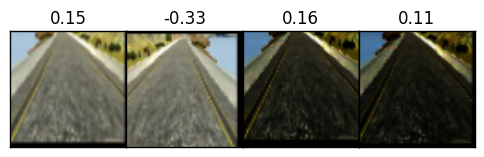

In [67]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

img_base = load_image(f[1000])

gs = gridspec.GridSpec(1, 4, wspace=0.0, hspace=0.0)
for col in range(0,4):
    for row in range(0,1):
        ax = plt.subplot(gs[row,col])
        img, angle = generate_image(img_base, np.float32(y[1000]))
        ax.imshow(img)
        ax.set_title('{:2.2f}'.format(angle,))
        ax.set_xticks([])
        ax.set_yticks([])

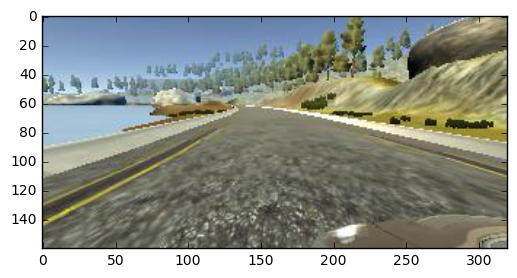

In [68]:
plt.imshow(img_base)

(array([  3.60000000e+01,   4.00000000e+00,   1.20000000e+01,
         1.20000000e+01,   2.30000000e+01,   4.70000000e+01,
         3.50000000e+01,   3.50000000e+01,   3.20000000e+01,
         7.50000000e+01,   4.90000000e+01,   5.80000000e+01,
         5.50000000e+01,   6.30000000e+01,   9.50000000e+01,
         7.10000000e+01,   9.80000000e+01,   1.17000000e+02,
         1.72000000e+02,   1.82000000e+02,   1.59000000e+02,
         2.48000000e+02,   7.09000000e+02,   9.11000000e+02,
         3.04200000e+03,   4.60000000e+02,   5.12000000e+02,
         9.53000000e+02,   1.00500000e+03,   8.53000000e+02,
         2.83400000e+03,   5.07000000e+02,   9.18000000e+02,
         9.02000000e+02,   3.10600000e+03,   4.36000000e+02,
         3.37000000e+02,   3.44000000e+02,   1.60000000e+02,
         2.46000000e+02,   1.17000000e+02,   8.80000000e+01,
         9.40000000e+01,   3.80000000e+01,   6.40000000e+01,
         4.70000000e+01,   6.50000000e+01,   5.70000000e+01,
         2.20000000e+01

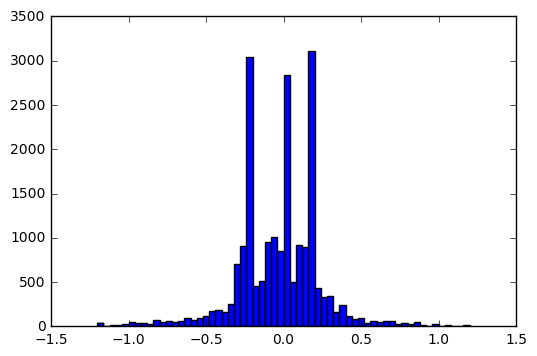

In [69]:

h = plt.hist(y, bins=60)
print(h)

In [72]:
def bin_data(f, y, bins):
    fb = {}
    yb = {}
    for idx, img in enumerate(f):
        bin = str((i for i,v in enumerate(bins) if v >= y[idx]).__next__())
        if bin in fb:
            fb[bin].append(img)
            yb[bin].append(y[idx])
        else:
            fb[bin] = [img]
            yb[bin] = [y[idx]]
    return fb, yb

fb, yb = bin_data(f, y, bins = (-999, -0.4, -0.2, -0.1, 0.1, 0.2, 0.4, 999 ))

print([ 'bin:{}={}'.format(k,len(fb[k])) for k in sorted(fb.keys())])
print(sum([len(fb[k]) for k in fb.keys()]))


['bin:1=1271', 'bin:2=5069', 'bin:3=1398', 'bin:4=6157', 'bin:5=4495', 'bin:6=1523', 'bin:7=784']
20697


In [73]:
def generate_balanced(fb, yb, n):
    while True:
        xs = []
        ys = []
        for _ in range(n):
            bin = np.random.randint(low=1, high=8)
            l = len(fb[str(bin)])
            i = np.random.randint(low=0,high=l)
            img, angle = generate_image(load_image(fb[str(bin)][i]),yb[str(bin)][i])
            xs.append(img)
            ys.append(angle)
        yield (np.asarray(xs), np.asarray(ys))
    
g = generate_balanced(fb, yb, 10000)
fg, yg = g.__next__()

(array([   7.,    5.,    5.,    8.,   15.,   18.,   18.,   27.,   32.,
          44.,   53.,   50.,   41.,   69.,  103.,  110.,  122.,  141.,
         141.,  176.,  178.,  294.,  302.,  378.,  353.,  394.,  453.,
         473.,  498.,  532.,  483.,  500.,  459.,  447.,  421.,  372.,
         364.,  287.,  251.,  190.,  148.,  157.,  142.,  120.,  119.,
          69.,   80.,   70.,   70.,   48.,   42.,   30.,   30.,   17.,
          16.,    6.,    5.,    2.,    9.,    6.]),
 array([-1.3921771 , -1.34567791, -1.29917872, -1.25267953, -1.20618034,
        -1.15968115, -1.11318196, -1.06668277, -1.02018358, -0.97368439,
        -0.9271852 , -0.88068601, -0.83418682, -0.78768763, -0.74118844,
        -0.69468925, -0.64819006, -0.60169087, -0.55519168, -0.50869249,
        -0.4621933 , -0.41569411, -0.36919492, -0.32269573, -0.27619654,
        -0.22969735, -0.18319816, -0.13669897, -0.09019978, -0.04370059,
         0.0027986 ,  0.04929779,  0.09579698,  0.14229617,  0.18879536,
         0.

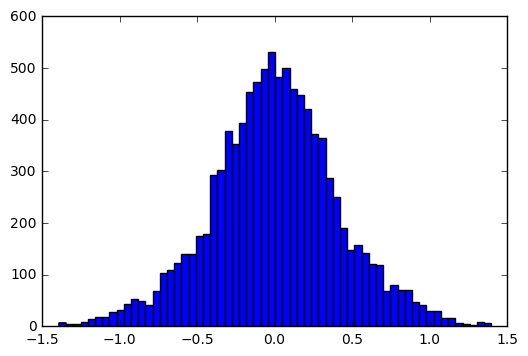

In [74]:
plt.hist(yg, bins = 60)

In [ ]:

parser = argparse.ArgumentParser(description='Train Model')
parser.add_argument('--model', type=str, help='Optional path to model to continue training')
args = parser.parse_args()

image_dir = 'data/images_run01/'

if args.model:
    print('Loading model for continued training!')
    with open(args.model, 'r') as f:
        json = f.read()
        model = model_from_json(json)
else:
    print('Training new model!')
    model = get_model()
    remove('clean_log.csv')
    remove('train_log.csv')
    remove('valid_log.csv')
    clean_driving_log('data/driving_log_3.csv', image_dir)
    split_driving_log('clean_log.csv',0.5)

n_train = file_len('train_log.csv') * 3 
n_valid = file_len('valid_log.csv') * 3

print(n_train, n_valid)

early_stopping_patience = 10
epochs_since_better = 0
n_epochs = 20
continue_training = True
consider_stopping = False
n_epoch = 0

batch_size = 1
n_batches = n_train / batch_size

model.compile(optimizer=Adam(lr=0.00001), loss="mse")

if args.model:
    model.load_weights('model.h5')
    best_mse = model.evaluate_generator(
        generator_all(image_dir,'valid_log.csv'),
        val_samples = 1)
else:
    best_mse = float("inf")
    
while n_epoch < n_epochs and continue_training:
    
    model.fit_generator(
        generator_random_zero(batch_size, image_dir,'train_log.csv'),
        samples_per_epoch=n_batches,
        nb_epoch=1, verbose=0)

    mse = model.evaluate_generator(
        generator_all_batch(2,image_dir,'valid_log.csv'),
        val_samples = 1)
    
    print(mse)
    
    # Early stopping?
    if mse > best_mse:    
        if consider_stopping:
            epochs_since_better += 1
        else:
            consider_stopping = True
            epochs_since_better = 1
    else:
        print('Improved accuracy of {} at epoch {}'.format(mse,n_epoch))
        best_mse = mse
        json = model.to_json()
        with open('model.json', 'w') as f:
            f.write(json)  
        model.save_weights('model.h5')
        consider_stopping = False

    if epochs_since_better > early_stopping_patience:
        print('Stopping no improvement for {} epochs'.format(early_stopping_patience))
        continue_training = False

    
    n_epoch += 1


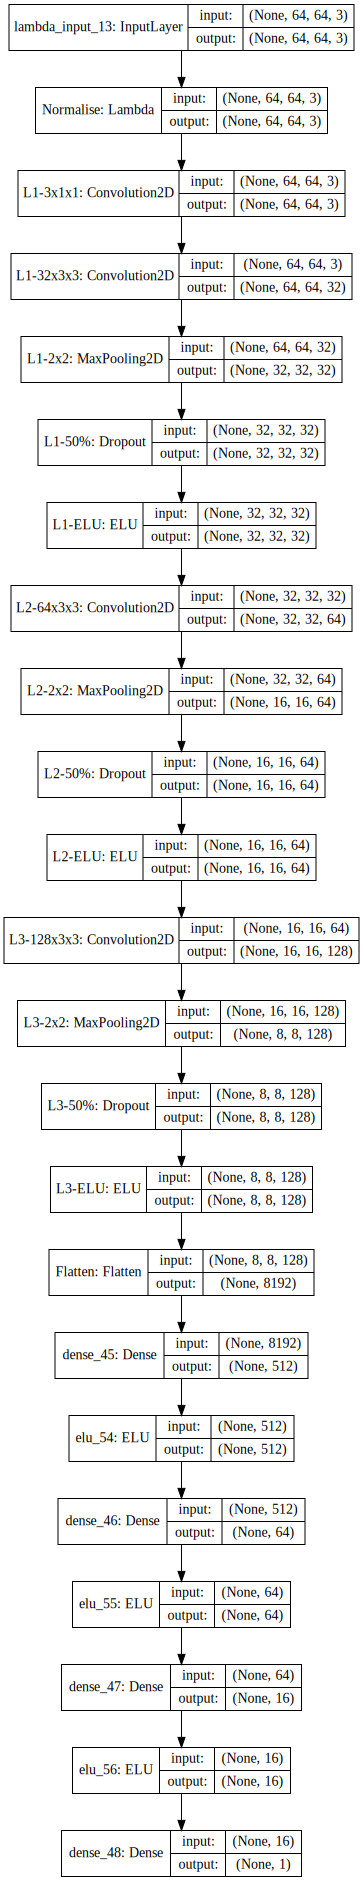

In [55]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

def get_model():
    ch, row, col = 3, 64, 64  

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=( row, col, ch),
            output_shape=( row, col, ch), name = 'Normalise'))
    model.add(Convolution2D(3, 1, 1, border_mode="same", name = 'L1-3x1x1'))
    model.add(Convolution2D(32, 3, 3, border_mode="same", name = 'L1-32x3x3'))
    model.add(MaxPooling2D(pool_size=(2,2), name='L1-2x2'))
    model.add(Dropout(0.5, name='L1-50%'))
    model.add(ELU(name='L1-ELU'))
    model.add(Convolution2D(64, 3, 3, border_mode="same", name = 'L2-64x3x3'))
    model.add(MaxPooling2D(pool_size=(2,2), name='L2-2x2'))
    model.add(Dropout(0.5, name='L2-50%'))
    model.add(ELU(name='L2-ELU'))
    model.add(Convolution2D(128, 3, 3, border_mode="same", name='L3-128x3x3'))
    model.add(MaxPooling2D(pool_size=(2,2), name='L3-2x2'))
    model.add(Dropout(0.5, name='L3-50%'))   
    model.add(ELU(name='L3-ELU'))
    model.add(Flatten(name='Flatten'))
    model.add(Dense(512))
    model.add(ELU())
    model.add(Dense(64))
    model.add(ELU())
    model.add(Dense(16))
    model.add(ELU())
    model.add(Dense(1))
    return model


model = get_model()

SVG(model_to_dot(model, show_shapes = True, show_layer_names = True).create(prog='dot', format='svg'))